In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util
from cartopy.util import add_cyclic_point

# import regionmask

import seaborn as sns

# Analysis
# import os
import time
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
import pickle
import scipy.stats as stats
import glob
import os 

# Import Ngl with pyn_env active 
import Ngl

import metpy.calc as mpc
from metpy.units import units
from metpy.plots import Hodograph, SkewT

import warnings
warnings.filterwarnings('ignore')



In [2]:
# Grabbed from Brian M. to use time midpoints, not end periods
def cesm_correct_time(ds):
    """Given a Dataset, check for time_bnds,
       and use avg(time_bnds) to replace the time coordinate.
       Purpose is to center the timestamp on the averaging inverval.   
       NOTE: ds should have been loaded using `decode_times=False`
    """
    assert 'time_bnds' in ds
    assert 'time' in ds
    correct_time_values = ds['time_bnds'].mean(dim='nbnd')
    # copy any metadata:
    correct_time_values.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time": correct_time_values})
    ds = xr.decode_cf(ds)  # decode to datetime objects
    return ds

In [3]:
def open_cesm_dataset(fils):
    if isinstance(fils,list) and (len(fils)==1):
        ds = xr.open_dataset(fils[0], decode_times=False)
    elif isinstance(fils,list):
        ds = xr.open_mfdataset(fils, decode_times=False, combine='by_coords')
    else:
        ds = xr.open_dataset(fils, decode_times=False)
    assert 'time_bnds' in ds  # require time_bnds to derive average time
    bnd_dims = ds['time_bnds'].dims
    print(f"The time bounds dimension is {bnd_dims[1]}")
    time_correct = ds['time_bnds'].mean(dim=bnd_dims[1])
    time_correct.attrs = ds['time'].attrs
    ds = ds.assign_coords({"time":time_correct})
    ds = xr.decode_cf(ds)
    return ds

In [4]:
def regrid_data(fromthis, tothis, method=1):
    """Regrid data using various different methods"""

    #Import necessary modules:
    import xarray as xr

    if method == 1:
        # kludgy: spatial regridding only, seems like can't automatically deal with time
        if 'time' in fromthis.coords:
            result = [fromthis.isel(time=t).interp_like(tothis) for t,time in enumerate(fromthis['time'])]
            result = xr.concat(result, 'time')
            return result
        else:
            return fromthis.interp_like(tothis)
    elif method == 2:
        newlat = tothis['lat']
        newlon = tothis['lon']
        coords = dict(fromthis.coords)
        coords['lat'] = newlat
        coords['lon'] = newlon
        return fromthis.interp(coords)
    elif method == 3:
        newlat = tothis['lat']
        newlon = tothis['lon']
        ds_out = xr.Dataset({'lat': newlat, 'lon': newlon})
        regridder = xe.Regridder(fromthis, ds_out, 'bilinear')
        return regridder(fromthis)
    elif method==4:
        # geocat
        newlat = tothis['lat']
        newlon = tothis['lon']
        result = geocat.comp.linint2(fromthis, newlon, newlat, False)
        result.name = fromthis.name
        
        return result

In [5]:
def preprocess_h0(ds):
    
    # ds         = cesm_correct_time(ds)
    # ds['time'] = ds.indexes['time'].to_datetimeindex()     
    
    ## Add a few shorthand variables 
    ds['windSpeedBot'] = (('time','lat','lon'),    
                                    np.sqrt(ds['U'].isel(lev=-1).values**2 + ds['V'].isel(lev=-1).values**2) )
    ds['windSpeedBot'].attrs['units']   = "m/s"
        
    return ds

## Read in data

In [6]:
dataDir = '/glade/scratch/mdfowler/'

ctrlFile_h0 = dataDir+'f.cam6_3_112.FLTHIST_v0c.ne30.non-ogw-ubcT-effgw0.3-rdg_beta0.5.001.cam.h0.selVars.nc'
ctrl = xr.open_dataset(ctrlFile_h0, decode_times=True)
ctrl = cesm_correct_time(ctrl)


In [7]:
caseName = 'FLTHIST_v0c.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112.002'
dataDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

testFile_h0 = dataDir+caseName+'.cam.h0_selVars_1995-2000.nc'
test = xr.open_dataset(testFile_h0, decode_times=True)
test = cesm_correct_time(test)


In [8]:
caseName = 'FLTHIST_v0c.ne30pg3_ne30pg3_mg17.TestGustGlobal_ReduceCoefsUgust_cam6_3_112.002'
dataDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

testFileReduce_h0 = dataDir+caseName+'.cam.h0.selVars_1995-2000.nc'
testReduce = xr.open_dataset(testFileReduce_h0, decode_times=True)
testReduce = cesm_correct_time(testReduce)


In [9]:
caseName = 'FLTHIST_v0c.ne30pg3_ne30pg3_mg17.TestGustGlobal_0.5ugust_cam6_3_112.002'
dataDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

testFileHalf_h0 = dataDir+caseName+'.cam.h0.selVars_1995-2000.nc'
testHalf = xr.open_dataset(testFileHalf_h0, decode_times=True)
testHalf = cesm_correct_time(testHalf)


Quick test of some short F2000climo cases

In [6]:
caseName = 'F2000climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_CONTROL_cam6_3_112.002'
dataDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

ctrlFile_h0 = dataDir+caseName+'.cam.h0_selVars_95-97.nc'
ctrl = xr.open_dataset(ctrlFile_h0, decode_times=True)
ctrl = cesm_correct_time(ctrl)


In [7]:
caseName = 'F2000climo.ne30pg3_ne30pg3_mg17.TestGustGlobal_cam6_3_112.002'
dataDir = '/glade/scratch/mdfowler/archive/'+caseName+'/atm/hist/'

testFile_h0 = dataDir+caseName+'.cam.h0_selVars_95-97.nc'
test = xr.open_dataset(testFile_h0, decode_times=True)
test = cesm_correct_time(test)


In [8]:
## A few observational files would be helpful too... 
obsDir = '/glade/p/cesm/amwg/amwg_diagnostics/obs_data/'

gpcp_jja = xr.open_dataset(obsDir+'GPCP_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
gpcp_djf = xr.open_dataset(obsDir+'GPCP_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 

erai_jja = xr.open_dataset(obsDir+'ERAI_JJA_climo.nc', decode_times=False)   #PRECT in mm/day 
erai_djf = xr.open_dataset(obsDir+'ERAI_DJF_climo.nc', decode_times=False)   #PRECT in mm/day 


In [9]:
def meanTimeAndRegion(DS,monStart,monEnd,yrMin,yrMax,
                      minLat,maxLat,minLon,maxLon): 
    
    iTime = np.where( (DS['time.month']>=monStart) & (DS['time.month']<=monEnd) & 
                      (DS['time.year']>=yrMin) & (DS['time.year']<=yrMax) )[0]
    iLat  = np.where( (DS['lat']>=minLat) & (DS['lat']<=maxLat) )[0]
    iLon  = np.where( (DS['lon']>=minLon) & (DS['lon']<=maxLon) )[0]

    selDS     = DS.isel(time=iTime, lat=iLat, lon=iLon).mean(dim='time')
    
    print('Min year in DS: ', np.nanmin(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    print('Max year in DS: ', np.nanmax(DS.isel(time=iTime, lat=iLat, lon=iLon)['time.year'].values))
    
    return selDS


In [14]:
## Select a range of years and 

monStart = 6
monEnd   = 8
yrMin    = 1996
yrMax    = 2000

## Tropical NW Pacific
minLat     = 5
maxLat     = 30
minLon     = 90
maxLon     = 145   # Original domain

## Tropical NW Pacific
minLat     = -45
maxLat     = 45
minLon     = 0
maxLon     = 359   # Expanded domain


# ## ~global
# minLat     = -80
# maxLat     = 80
# minLon     = 0
# maxLon     = 359   

sel_ctrl = meanTimeAndRegion(ctrl,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_test = meanTimeAndRegion(test,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
# sel_testReduce = meanTimeAndRegion(testReduce,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
# sel_testHalf   = meanTimeAndRegion(testHalf,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()


## Select same region for obs comparison:
ilat = np.where( (erai_jja.lat.values>=minLat) & (erai_jja.lat.values<=maxLat) )[0]
ilon = np.where( (erai_jja.lon.values>=minLon) & (erai_jja.lon.values<=maxLon) )[0]
sel_erai_jja = erai_jja.isel(lat=ilat,lon=ilon)
sel_erai_djf = erai_djf.isel(lat=ilat,lon=ilon)

ilat2 = np.where( (gpcp_jja.lat.values>=minLat) & (gpcp_jja.lat.values<=maxLat) )[0]
ilon2 = np.where( (gpcp_jja.lon.values>=minLon) & (gpcp_jja.lon.values<=maxLon) )[0]
sel_gpcp_jja = gpcp_jja.isel(lat=ilat2,lon=ilon2)
sel_gpcp_djf = gpcp_djf.isel(lat=ilat2,lon=ilon2)

print('--- Done with selecting years/regions ---')


Min year in DS:  1996
Max year in DS:  1997
Min year in DS:  1996
Max year in DS:  1997
--- Done with selecting years/regions ---


In [11]:
def plotBiases_regridded(obsDS, obsVar, obsMultiplier,
                         dsCtrl, dsTest, dsTest2, dsTest3,
                         dsVar,
                         obsString, unitsString):
    
    ## Handle regridding the CAM data to obs grid
    # Get obs grid 
    obsGrid = obsDS[obsVar].isel(time=0).squeeze()*obsMultiplier

    # Now regrid the data
    regrid_ctrl    = regrid_data(dsCtrl, obsGrid, method=1)[dsVar]
    regrid_test    = regrid_data(dsTest, obsGrid, method=1)[dsVar]
    # regrid_test2   = regrid_data(dsTest2, obsGrid, method=1)[dsVar]
    # regrid_test3   = regrid_data(dsTest3, obsGrid, method=1)[dsVar]

    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Get colorbar limits for raw data and for biases 
    maxRawVal = np.nanmax( [np.nanpercentile(obsGrid,     98),
                            np.nanpercentile(regrid_ctrl, 98),
                            np.nanpercentile(regrid_test, 98), 
                            # np.nanpercentile(regrid_test2, 98), 
                            # np.nanpercentile(regrid_test3, 98), 
                           ] )
    
    minRawVal = np.nanmin( [np.nanpercentile(obsGrid,      2),
                            np.nanpercentile(regrid_ctrl,  2),
                            np.nanpercentile(regrid_test,  2),
                            # np.nanpercentile(regrid_test2,  2),
                            # np.nanpercentile(regrid_test3,  2),
                           ] )
    levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
    # levsMap = np.arange(0,250,5)   # non-flexible optoin; works for LHFLX if want to match plot with gust sims 
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of raw data 
    fig,axs = plt.subplots(2,5, figsize=(25,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.3)
    
    # Plot observations 
    contour_plot = axs[0].contourf(obsGrid.lon.values, obsGrid.lat.values, np.squeeze(obsGrid), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[0].coastlines()
    axs[0].set_extent([np.nanmin(obsGrid.lon.values)-2,np.nanmax(obsGrid.lon.values)+2,
                       np.nanmin(obsGrid.lat.values)-2,np.nanmax(obsGrid.lat.values)+2], crs=ccrs.PlateCarree())
    axs[0].set_title(obsString+' '+obsVar)
    
    # Plot model data 
    contour_plot = axs[1].contourf(regrid_ctrl.lon.values, regrid_ctrl.lat.values, np.squeeze(regrid_ctrl), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[1].coastlines()
    axs[1].set_extent([np.nanmin(regrid_ctrl.lon.values)-2,np.nanmax(regrid_ctrl.lon.values)+2,
                       np.nanmin(regrid_ctrl.lat.values)-2,np.nanmax(regrid_ctrl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[1].set_title('CTRL: '+dsVar)
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    
    contour_plot = axs[2].contourf(regrid_test.lon.values, regrid_test.lat.values, np.squeeze(regrid_test), 
                                    levsMap,
                                    cmap='gnuplot2',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[2].coastlines()
    axs[2].set_extent([np.nanmin(regrid_test.lon.values)-2,np.nanmax(regrid_test.lon.values)+2,
                       np.nanmin(regrid_test.lat.values)-2,np.nanmax(regrid_test.lat.values)+2], crs=ccrs.PlateCarree())
    axs[2].set_title('TEST: '+dsVar)
    
#     contour_plot = axs[3].contourf(regrid_test2.lon.values, regrid_test2.lat.values, np.squeeze(regrid_test2), 
#                                     levsMap,
#                                     cmap='gnuplot2',extend='both',
#                                     transform=ccrs.PlateCarree())
#     axs[3].coastlines()
#     axs[3].set_extent([np.nanmin(regrid_test.lon.values)-2,np.nanmax(regrid_test.lon.values)+2,
#                        np.nanmin(regrid_test.lat.values)-2,np.nanmax(regrid_test.lat.values)+2], crs=ccrs.PlateCarree())
#     axs[3].set_title('TEST2: '+dsVar)
    
#     contour_plot = axs[4].contourf(regrid_test3.lon.values, regrid_test3.lat.values, np.squeeze(regrid_test3), 
#                                     levsMap,
#                                     cmap='gnuplot2',extend='both',
#                                     transform=ccrs.PlateCarree())
#     axs[4].coastlines()
#     axs[4].set_extent([np.nanmin(regrid_test.lon.values)-2,np.nanmax(regrid_test.lon.values)+2,
#                        np.nanmin(regrid_test.lat.values)-2,np.nanmax(regrid_test.lat.values)+2], crs=ccrs.PlateCarree())
#     axs[4].set_title('TEST3: '+dsVar)
    
    
            
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of biases 
    
    ## Plot difference 
    diffVarCtl  = np.squeeze(regrid_ctrl) - np.squeeze(obsGrid)
    diffVarTest = np.squeeze(regrid_test) - np.squeeze(obsGrid)
    # diffVarTest2 = np.squeeze(regrid_test2) - np.squeeze(obsGrid)
    # diffVarTest3 = np.squeeze(regrid_test3) - np.squeeze(obsGrid)

    cMax = np.nanmax( [ np.nanpercentile(diffVarCtl, 98),
                        np.nanpercentile(diffVarTest, 98),
                        # np.nanpercentile(diffVarTest2, 98),
                        # np.nanpercentile(diffVarTest3, 98),
                      ] )
    
    cMin = np.nanmin( [ np.nanpercentile(diffVarCtl,  2),
                        np.nanpercentile(diffVarTest,  2),
                        # np.nanpercentile(diffVarTest2,  2),
                        # np.nanpercentile(diffVarTest3,  2),
                      ] )

    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    levsDiff  = np.arange(-evenPoint, (evenPoint+cStep), cStep ) 
    
    
    
    contour_plot = axs[6].contourf(diffVarCtl.lon.values, diffVarCtl.lat.values, np.squeeze(diffVarCtl), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[6].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width+0.2, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    axs[6].coastlines()
    axs[6].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
                       np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[6].set_title('CTRL - '+obsString+': ')
    
        
    contour_plot = axs[7].contourf(diffVarTest.lon.values, diffVarTest.lat.values, np.squeeze(diffVarTest), 
                                    levsDiff,
                                    cmap='bwr',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[7].coastlines()
    axs[7].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
                       np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[7].set_title('TEST - '+obsString+': ')   
            
#     contour_plot = axs[8].contourf(diffVarTest2.lon.values, diffVarTest2.lat.values, np.squeeze(diffVarTest2), 
#                                     levsDiff,
#                                     cmap='bwr',extend='both',
#                                     transform=ccrs.PlateCarree())
#     axs[8].coastlines()
#     axs[8].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
#                        np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
#     axs[8].set_title('TEST2 - '+obsString+': ')   
    
            
#     contour_plot = axs[9].contourf(diffVarTest3.lon.values, diffVarTest3.lat.values, np.squeeze(diffVarTest3), 
#                                     levsDiff,
#                                     cmap='bwr',extend='both',
#                                     transform=ccrs.PlateCarree())
#     axs[9].coastlines()
#     axs[9].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
#                        np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
#     axs[9].set_title('TEST3 - '+obsString+': ')   
    
    
    axs[5].set_visible(False)
        
    return axs

In [34]:
def plotDiffs_regridded(obsDS, obsVar, obsMultiplier,
                         dsCtrl, dsTest, dsTest2, dsTest3, 
                         dsVar,
                         obsString, unitsString):
    
    ## Handle regridding the CAM data to obs grid
    # Get obs grid 
    obsGrid = obsDS[obsVar].isel(time=0).squeeze()*obsMultiplier

    # Now regrid the data
    regrid_ctrl     = regrid_data(dsCtrl, obsGrid, method=1)[dsVar]
    regrid_test     = regrid_data(dsTest, obsGrid, method=1)[dsVar]
    regrid_test2    = regrid_data(dsTest2, obsGrid, method=1)[dsVar]
    regrid_test3    = regrid_data(dsTest3, obsGrid, method=1)[dsVar]
    
    model_diffs     = regrid_test - regrid_ctrl
    model_diffs2    = regrid_test2 - regrid_ctrl
    model_diffs3    = regrid_test3 - regrid_ctrl

    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Get colorbar limits for raw data and for biases 
    maxRawVal = np.nanmax( [np.nanpercentile(model_diffs,     98),
                            np.nanpercentile(model_diffs2,     98),
                            np.nanpercentile(model_diffs3,     98),
                           ] )
    minRawVal = np.nanmin( [np.nanpercentile(model_diffs,      2),
                            np.nanpercentile(model_diffs2,      2),
                            np.nanpercentile(model_diffs3,      2),
                           ] )
    levsMap    = np.arange(minRawVal, maxRawVal, (maxRawVal-minRawVal)/100.0)
    # levsMap = np.arange(0,250,5)   # non-flexible optoin; works for LHFLX if want to match plot with gust sims 
    
    
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of raw data 
    fig,axs = plt.subplots(2,3, figsize=(18,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=180)})
    axs     = axs.ravel()
    fig.subplots_adjust(hspace=0.5)
     
    # Plot model data 
    contour_plot = axs[0].contourf(regrid_ctrl.lon.values, regrid_ctrl.lat.values, np.squeeze(model_diffs), 
                                    levsMap,
                                    cmap='PRGn',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[0].coastlines()
    axs[0].set_extent([np.nanmin(regrid_ctrl.lon.values)-2,np.nanmax(regrid_ctrl.lon.values)+2,
                       np.nanmin(regrid_ctrl.lat.values)-2,np.nanmax(regrid_ctrl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[0].set_title('Test-CTRL: '+dsVar)

    contour_plot = axs[1].contourf(regrid_ctrl.lon.values, regrid_ctrl.lat.values, np.squeeze(model_diffs2), 
                                    levsMap,
                                    cmap='PRGn',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[1].coastlines()
    axs[1].set_extent([np.nanmin(regrid_ctrl.lon.values)-2,np.nanmax(regrid_ctrl.lon.values)+2,
                       np.nanmin(regrid_ctrl.lat.values)-2,np.nanmax(regrid_ctrl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[1].set_title('Test2-CTRL: '+dsVar)
    # Add colorbar
    ax_position = axs[1].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    contour_plot = axs[2].contourf(regrid_ctrl.lon.values, regrid_ctrl.lat.values, np.squeeze(model_diffs3), 
                                    levsMap,
                                    cmap='PRGn',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[2].coastlines()
    axs[2].set_extent([np.nanmin(regrid_ctrl.lon.values)-2,np.nanmax(regrid_ctrl.lon.values)+2,
                       np.nanmin(regrid_ctrl.lat.values)-2,np.nanmax(regrid_ctrl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[2].set_title('Test3-CTRL: '+dsVar)


            
    ## - - - - - - - - - - - - - - - - - - - - - - - - - -
    ## Make cool plots of biases 
    
    ## Plot difference 
    diffVarCtl  = np.squeeze(regrid_ctrl) - np.squeeze(obsGrid)
    diffVarTest  = np.squeeze(regrid_test) - np.squeeze(obsGrid)
    diffVarTest2 = np.squeeze(regrid_test2) - np.squeeze(obsGrid)
    diffVarTest3 = np.squeeze(regrid_test3) - np.squeeze(obsGrid)
    
    diffBias = np.abs(diffVarTest) - np.abs(diffVarCtl)
    diffBias2 = np.abs(diffVarTest2) - np.abs(diffVarCtl)
    diffBias3 = np.abs(diffVarTest3) - np.abs(diffVarCtl)

    cMax = np.nanmax( [ np.nanpercentile(diffBias, 98),
                        np.nanpercentile(diffBias2, 98), 
                        np.nanpercentile(diffBias3, 98),
                      ] )
    
    cMin = np.nanmin( [ np.nanpercentile(diffBias,  2),
                        np.nanpercentile(diffBias2,  2), 
                        np.nanpercentile(diffBias3,  2),
                      ] )

    evenPoint = np.nanmax([abs(cMax),abs(cMin)]) 
    cStep     = (evenPoint*2)/100.0
    levsDiff  = np.arange(-evenPoint, (evenPoint+cStep), cStep ) 
    
    
    contour_plot = axs[3].contourf(diffVarCtl.lon.values, diffVarCtl.lat.values, np.squeeze(diffBias), 
                                    levsDiff,
                                    cmap='PuOr_r',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[3].coastlines()
    axs[3].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
                      np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[3].set_title('|TESTbias|-|CTRLbias| (delta_abs(bias))- '+obsString+': ')
    
    
    contour_plot = axs[4].contourf(diffVarCtl.lon.values, diffVarCtl.lat.values, np.squeeze(diffBias2), 
                                    levsDiff,
                                    cmap='PuOr_r',extend='both',
                                    transform=ccrs.PlateCarree())
    # Add colorbar
    ax_position = axs[4].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.08, ax_position.width, 0.03])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
    cbar.set_label(unitsString,fontsize=11)
    
    axs[4].coastlines()
    axs[4].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
                      np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[4].set_title('|TEST2bias|-|CTRLbias| (delta_abs(bias))- '+obsString+': ')
    
    
    contour_plot = axs[5].contourf(diffVarCtl.lon.values, diffVarCtl.lat.values, np.squeeze(diffBias3), 
                                    levsDiff,
                                    cmap='PuOr_r',extend='both',
                                    transform=ccrs.PlateCarree())
    axs[5].coastlines()
    axs[5].set_extent([np.nanmin(diffVarCtl.lon.values)-2,np.nanmax(diffVarCtl.lon.values)+2,
                      np.nanmin(diffVarCtl.lat.values)-2,np.nanmax(diffVarCtl.lat.values)+2], crs=ccrs.PlateCarree())
    axs[5].set_title('|TEST3bias|-|CTRLbias| (delta_abs(bias))- '+obsString+': ')
    
        
    return axs

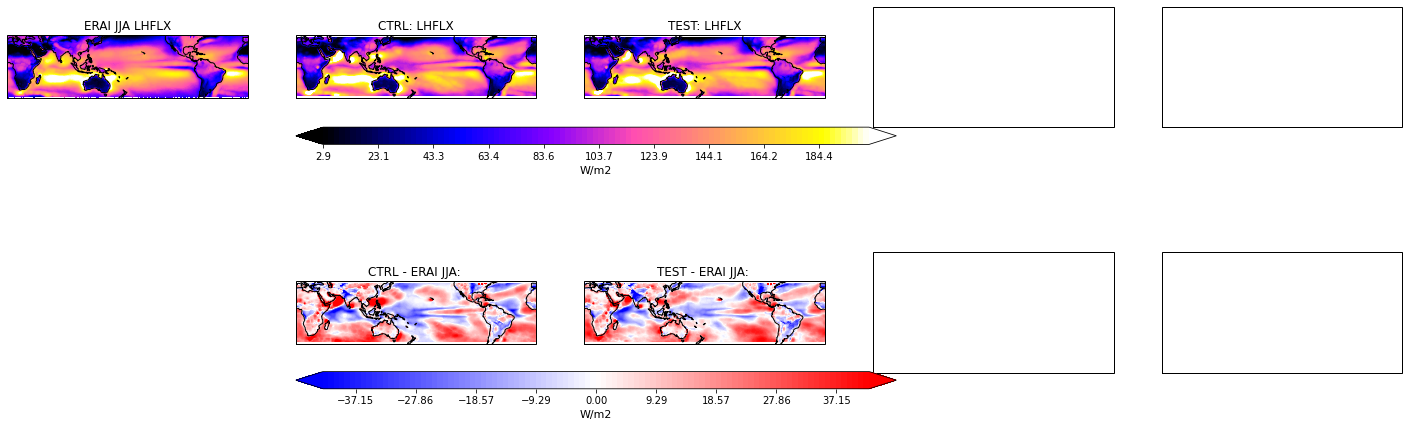

In [15]:
axs = plotBiases_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_ctrl, sel_test, 
                           sel_test,sel_test,
                           # sel_testReduce, sel_testHalf,
                           'LHFLX',
                           'ERAI JJA', 'W/m2')


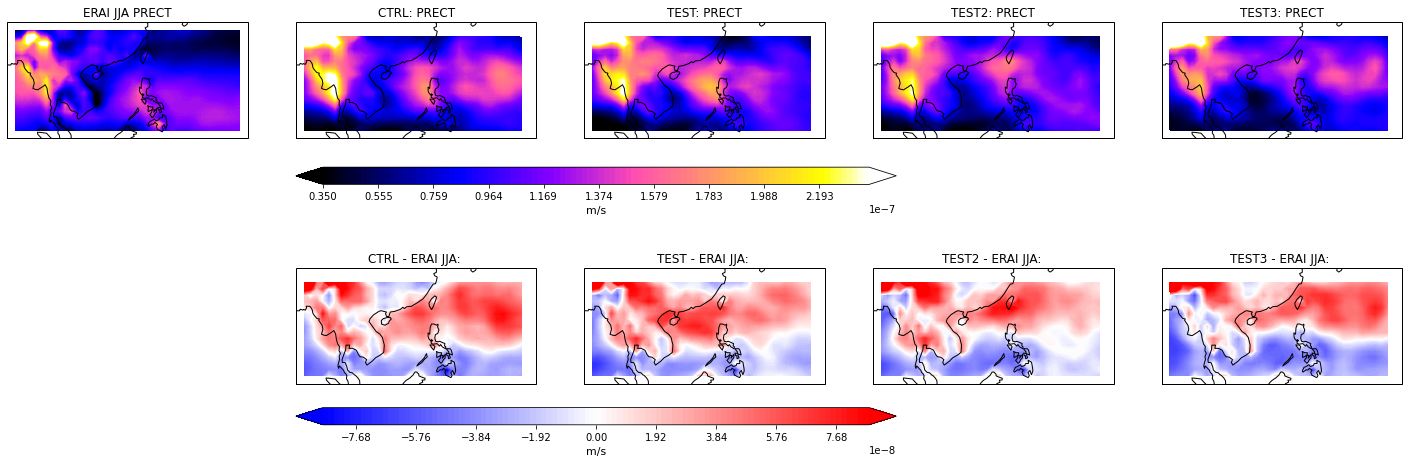

In [31]:
axs = plotBiases_regridded(sel_erai_jja, 'PRECT', 1/86400000.0 ,
                           sel_ctrl, sel_test, 
                           sel_testReduce, sel_testHalf,
                           'PRECT',
                           'ERAI JJA', 'm/s')


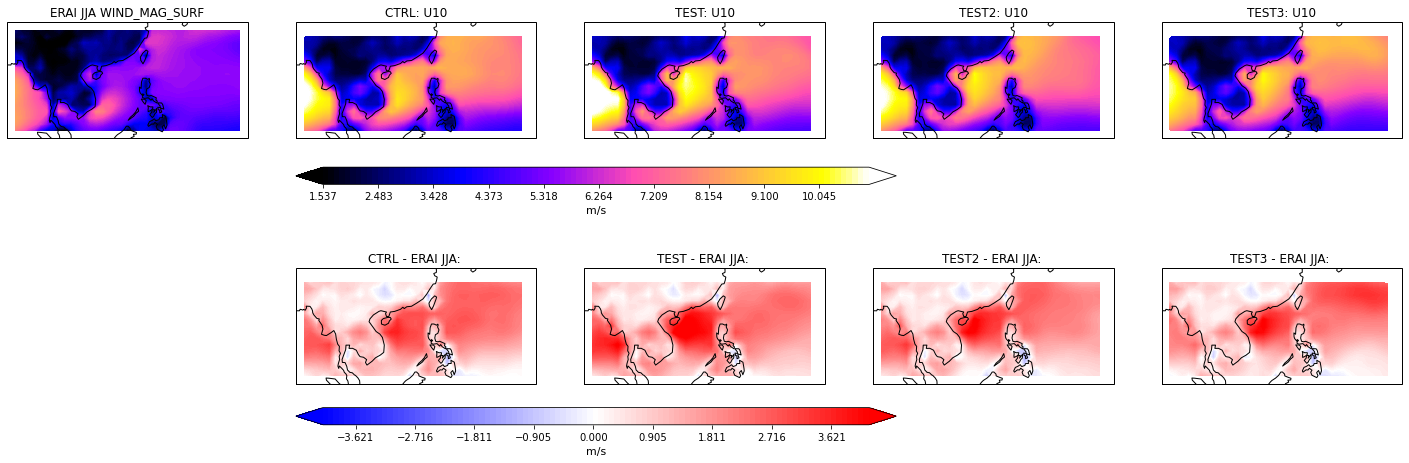

In [32]:
axs = plotBiases_regridded(sel_erai_jja, 'WIND_MAG_SURF', 1,
                           sel_ctrl, sel_test, sel_testReduce, sel_testHalf, 
                           'U10',
                           'ERAI JJA', 'm/s')


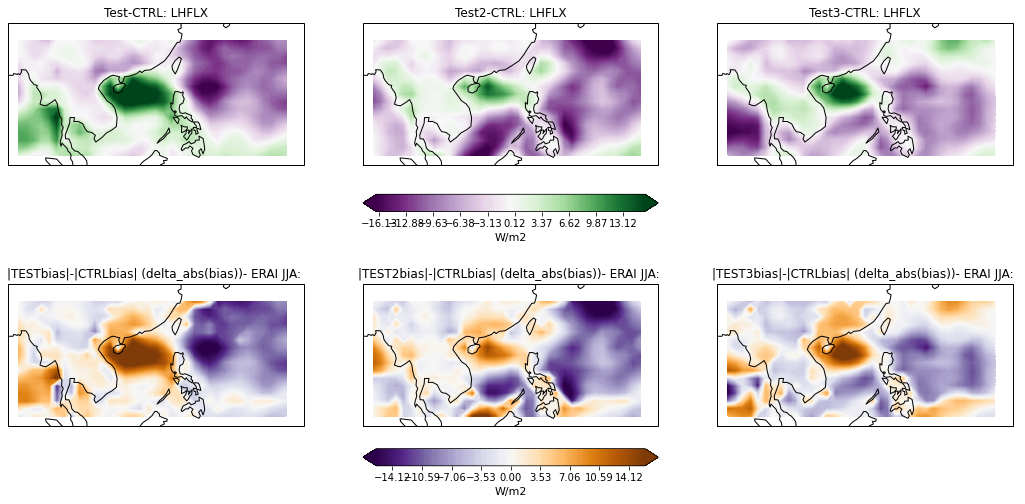

In [35]:
axs = plotDiffs_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_ctrl, sel_test, sel_testReduce, sel_testHalf,
                           'LHFLX',
                           'ERAI JJA', 'W/m2')


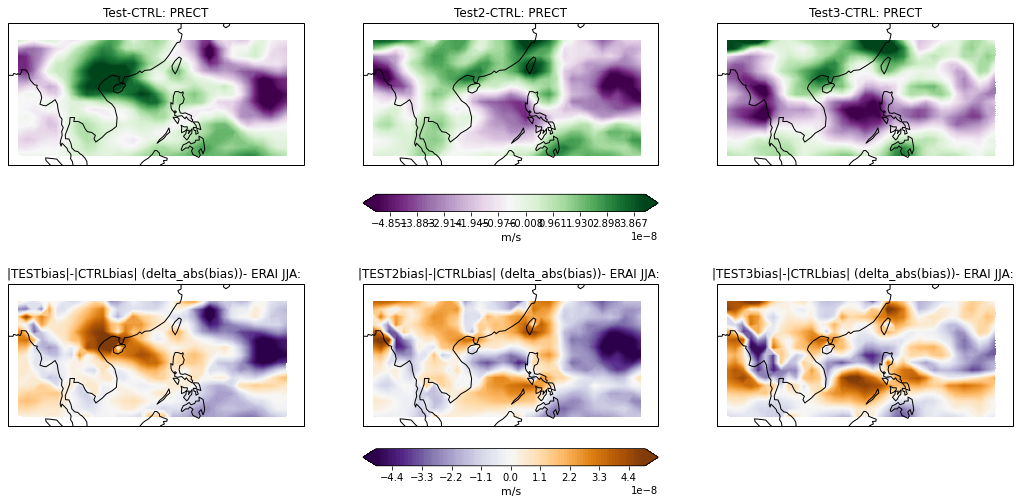

In [36]:
axs = plotDiffs_regridded(sel_erai_jja, 'PRECT', 1/86400000.0 ,
                           sel_ctrl, sel_test, sel_testReduce, sel_testHalf,
                          'PRECT',
                           'ERAI JJA', 'm/s')


## Global (& JJA)

In [38]:
## Select a range of years and 

monStart = 6
monEnd   = 8
yrMin    = 1996
yrMax    = 1997

# ## Tropical NW Pacific
# minLat     = 5
# maxLat     = 30
# minLon     = 90
# maxLon     = 145   # Original domain

## ~global
minLat     = -80
maxLat     = 80
minLon     = 0
maxLon     = 359   

sel_ctrl = meanTimeAndRegion(ctrl,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_test = meanTimeAndRegion(test,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_testReduce = meanTimeAndRegion(testReduce,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()
sel_testHalf = meanTimeAndRegion(testHalf,monStart,monEnd,yrMin,yrMax,minLat,maxLat,minLon,maxLon).load()


## Select same region for obs comparison:
ilat = np.where( (erai_jja.lat.values>=minLat) & (erai_jja.lat.values<=maxLat) )[0]
ilon = np.where( (erai_jja.lon.values>=minLon) & (erai_jja.lon.values<=maxLon) )[0]
sel_erai_jja = erai_jja.isel(lat=ilat,lon=ilon)
sel_erai_djf = erai_djf.isel(lat=ilat,lon=ilon)

ilat2 = np.where( (gpcp_jja.lat.values>=minLat) & (gpcp_jja.lat.values<=maxLat) )[0]
ilon2 = np.where( (gpcp_jja.lon.values>=minLon) & (gpcp_jja.lon.values<=maxLon) )[0]
sel_gpcp_jja = gpcp_jja.isel(lat=ilat2,lon=ilon2)
sel_gpcp_djf = gpcp_djf.isel(lat=ilat2,lon=ilon2)

print('--- Done with selecting years/regions ---')


Min year in DS:  1996
Max year in DS:  1997
Min year in DS:  1996
Max year in DS:  1997
Min year in DS:  1996
Max year in DS:  1997
Min year in DS:  1996
Max year in DS:  1997
--- Done with selecting years/regions ---


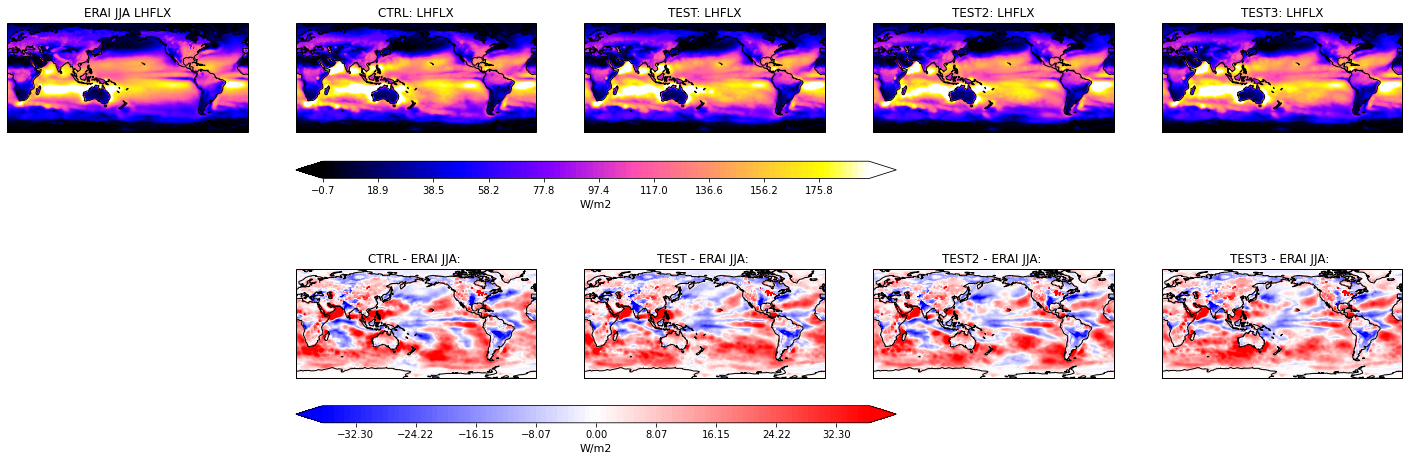

In [39]:
axs = plotBiases_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_ctrl, sel_test, sel_testReduce, sel_testHalf,
                           'LHFLX',
                           'ERAI JJA', 'W/m2')



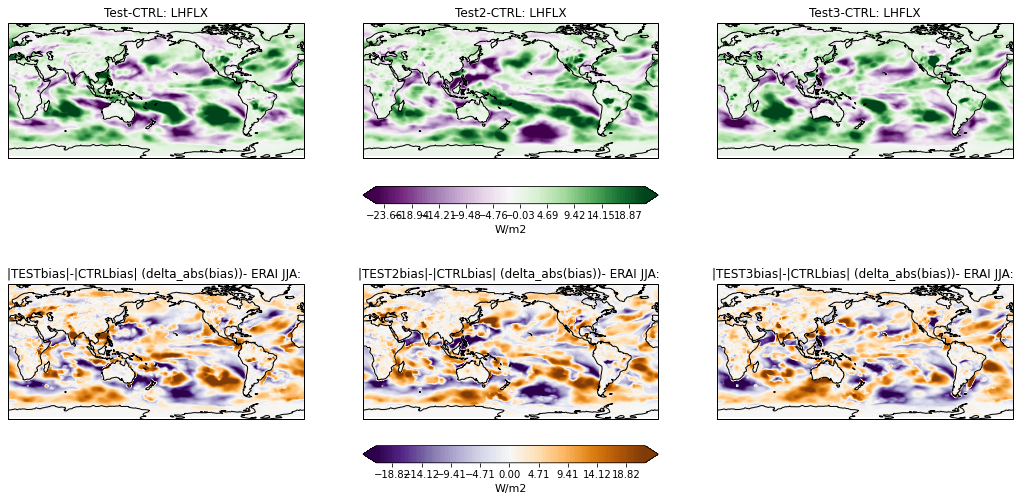

In [40]:
axs2 = plotDiffs_regridded(sel_erai_jja, 'LHFLX', 1,
                           sel_ctrl, sel_test,  sel_testReduce, sel_testHalf,
                           'LHFLX',
                           'ERAI JJA', 'W/m2')

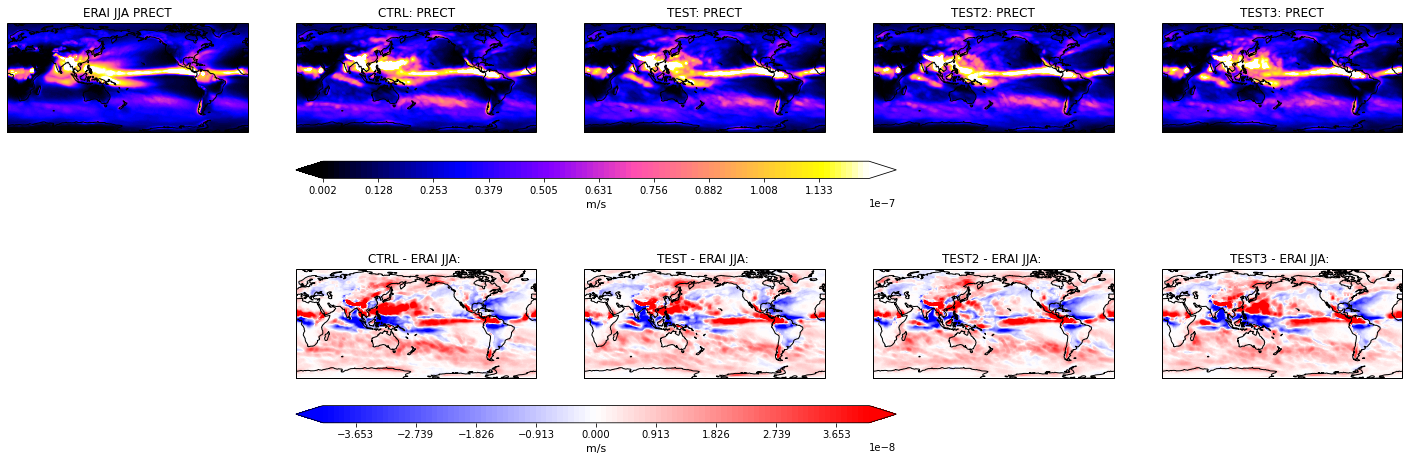

In [41]:
axs = plotBiases_regridded(sel_erai_jja, 'PRECT', 1/86400000.0 ,
                           sel_ctrl, sel_test,  sel_testReduce, sel_testHalf,
                           'PRECT',
                           'ERAI JJA', 'm/s')




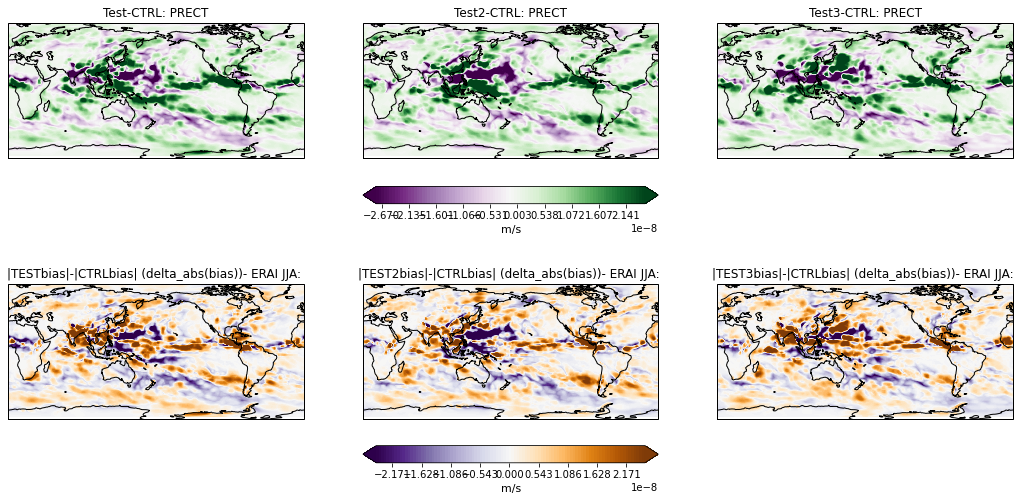

In [42]:
axs = plotDiffs_regridded(sel_erai_jja, 'PRECT', 1/86400000.0 ,
                           sel_ctrl, sel_test,  sel_testReduce, sel_testHalf,
                          'PRECT',
                           'ERAI JJA', 'm/s')